<a href="https://colab.research.google.com/github/MuHyeonSon/Medical_image_processing/blob/main/automatic_segmentation_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#segmentation할 data의 경로

segmentation을 수행할 데이터의 경로를 data_dir에 입력하세요.

In [ ]:
data_dir = '/content/drive/MyDrive/Digital_image_processing/project/brats18_test'



import os

if os.path.exists(data_dir):    # 지정된 경로가 존재하는지 여부를 확인
    print("경로 존재")
else:
    print("경로 존재X")

경로 존재


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#segmentaion수행

MONAI version: 0.9.dev2149
Numpy version: 1.19.5
Pytorch version: 1.10.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 1ad68787c35e259cb7704b56d679659104d2494c

Optional dependencies:
Pytorch Ignite version: 0.4.7
Nibabel version: 3.0.2
scikit-image version: 0.18.3
Pillow version: 7.1.2
Tensorboard version: 2.7.0
gdown version: 3.6.4
TorchVision version: 0.11.1+cu111
tqdm version: 4.62.3
lmdb version: 0.99
psutil version: 5.4.8
pandas version: 1.1.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



Loading dataset: 100%|██████████| 20/20 [00:02<00:00,  7.34it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


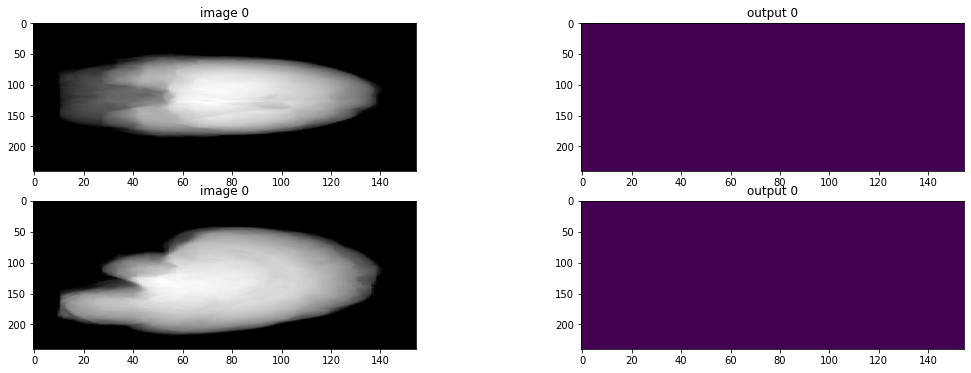

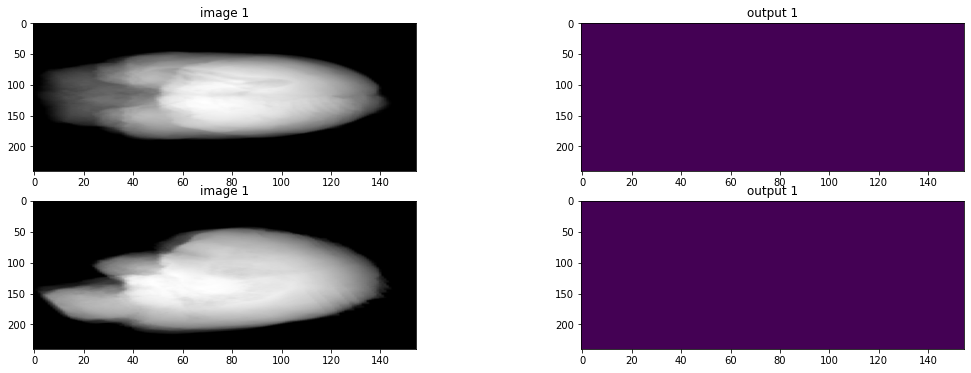

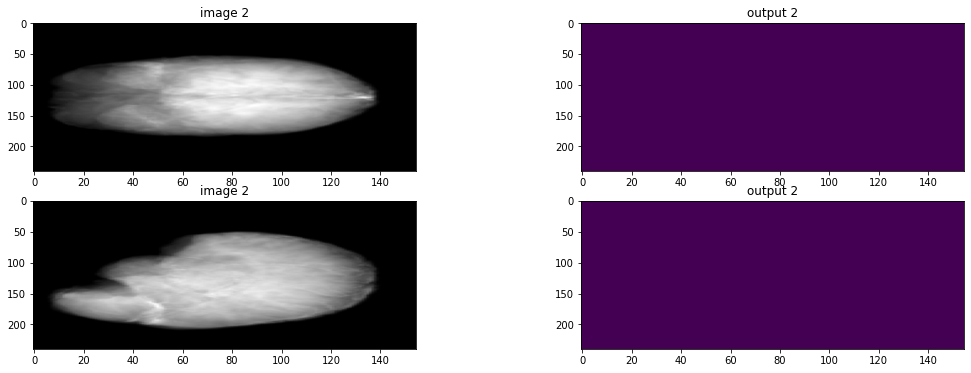

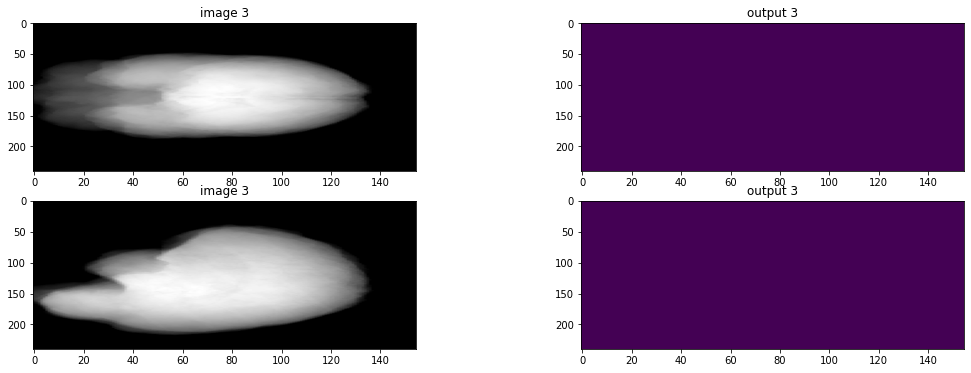

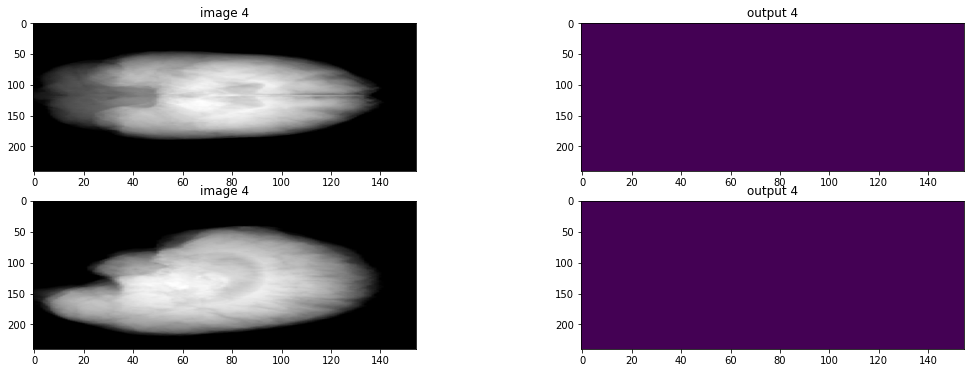

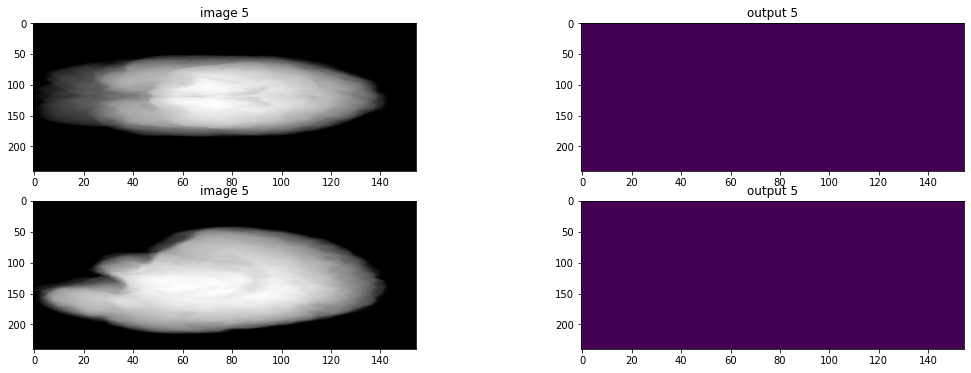

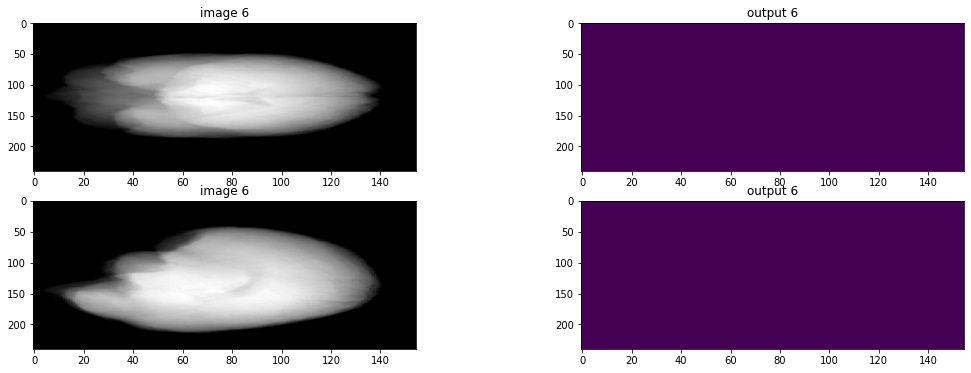

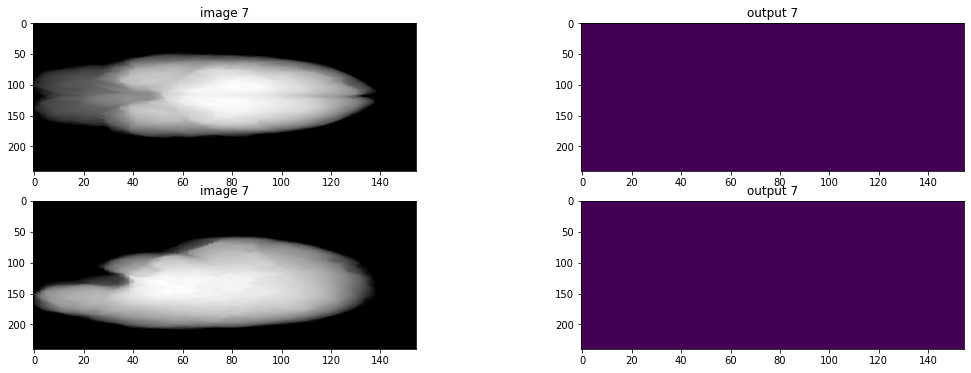

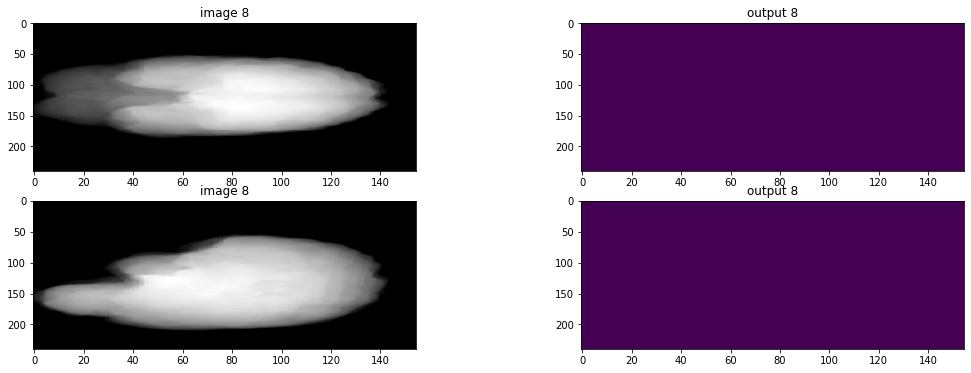

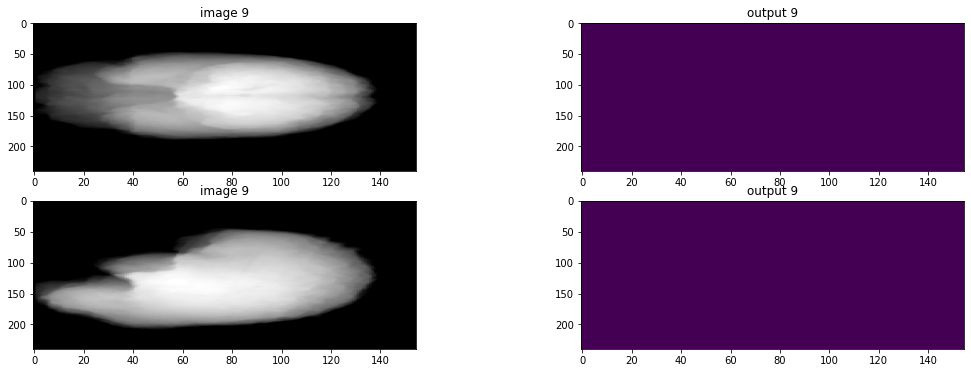

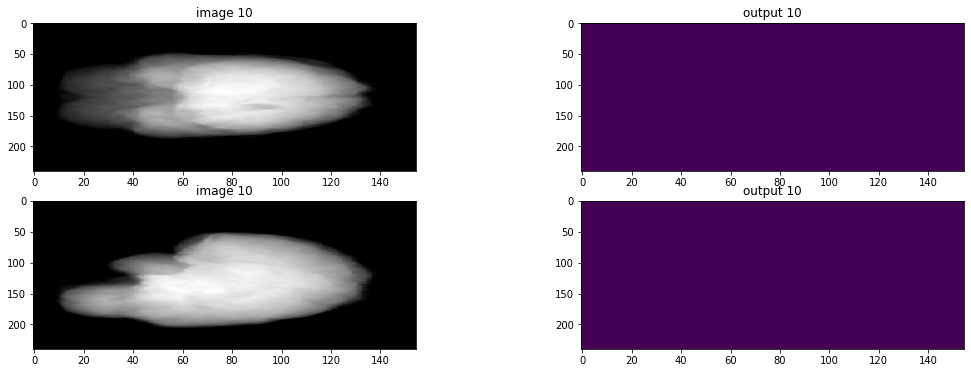

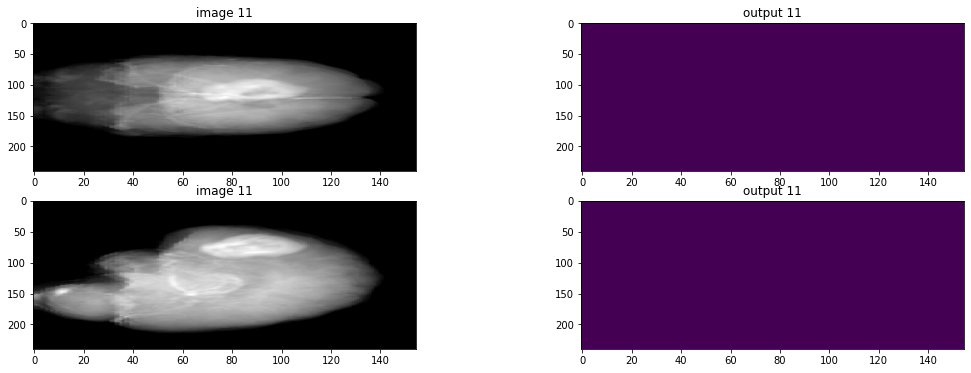

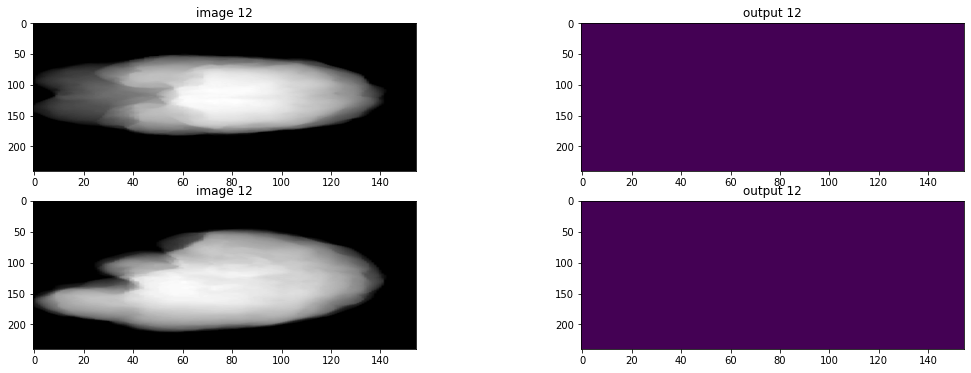

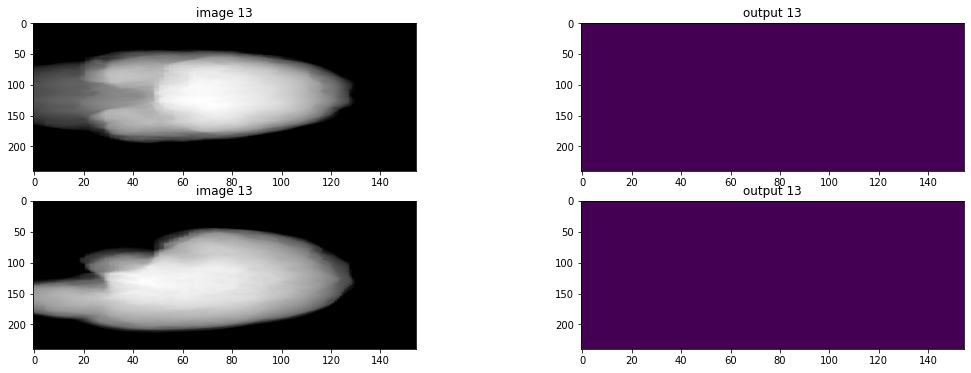

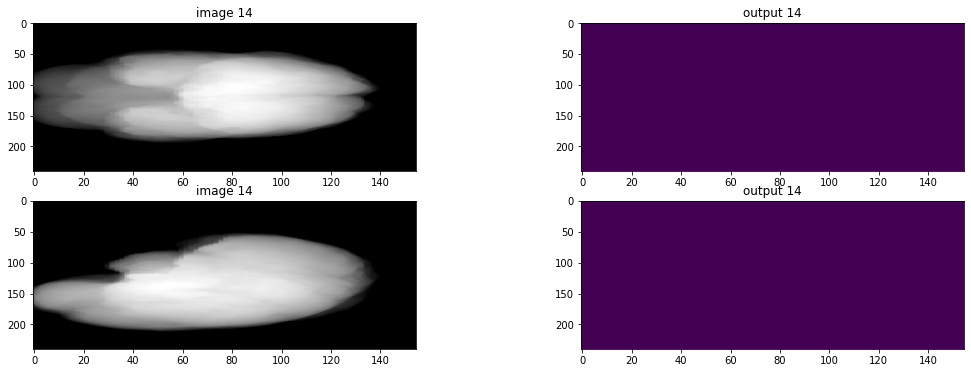

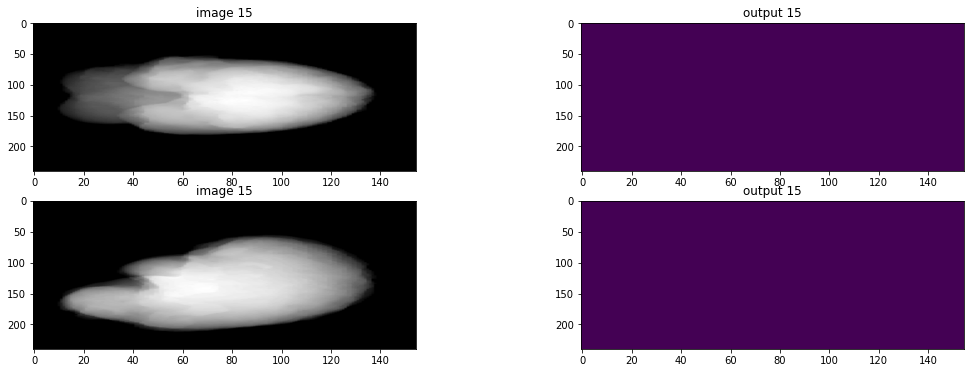

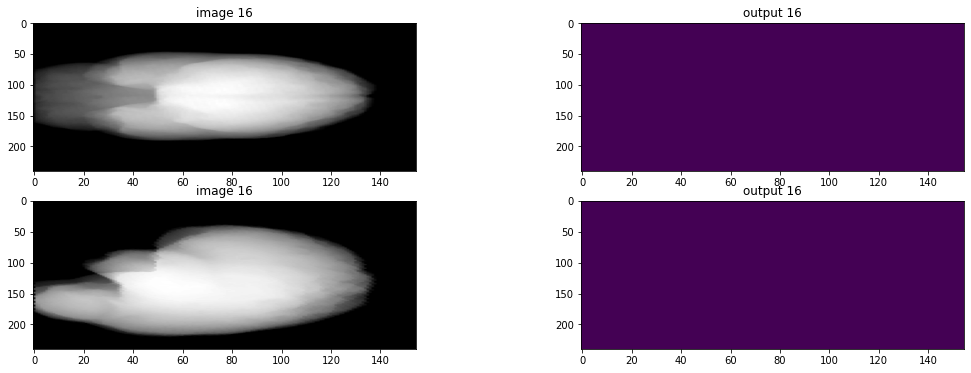

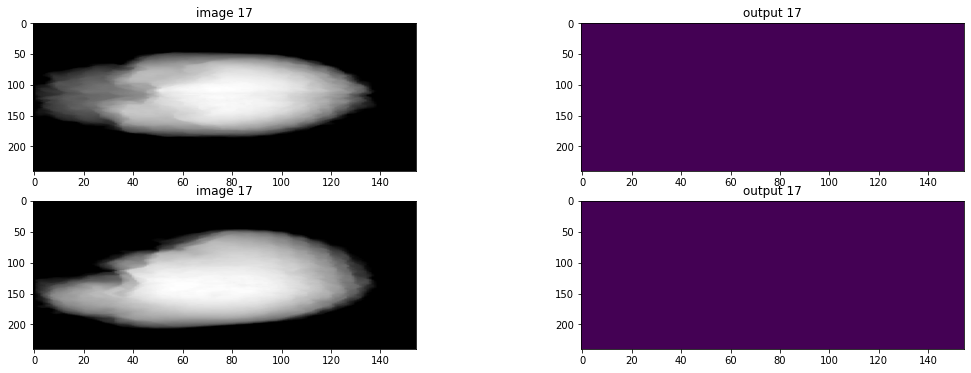

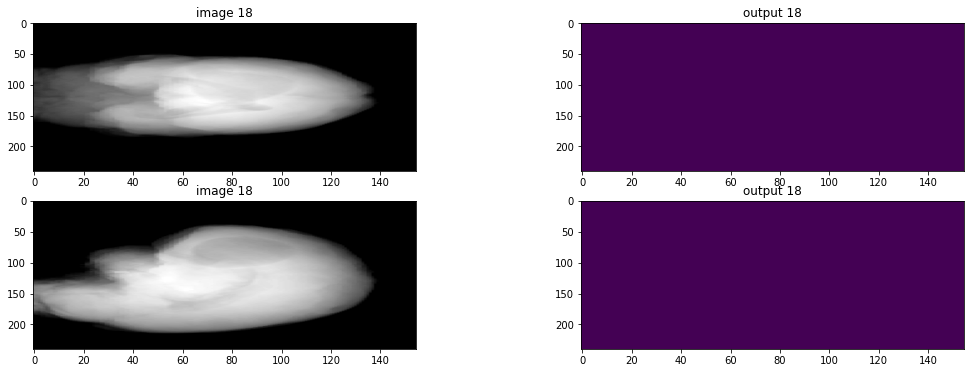

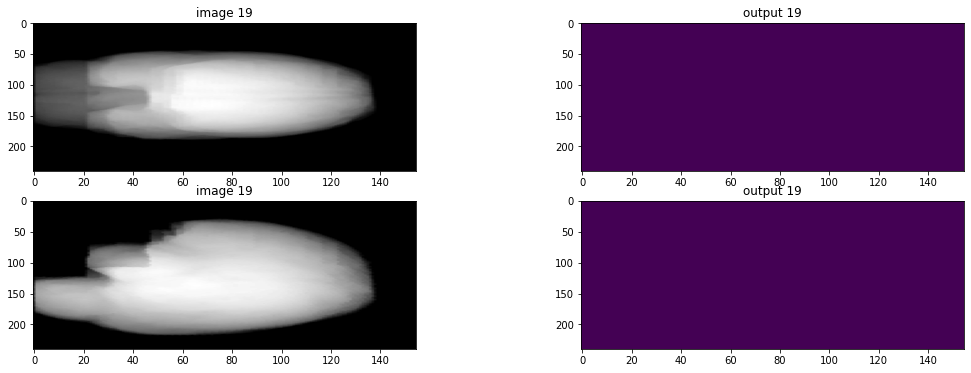

In [ ]:
# set up environment 

!pip install monai-weekly
!pip install pytorch-ignite
!pip install tmp

import logging
import sys
import shutil
import time
import tmp

import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import monai
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, ImageDataset, Dataset,decollate_batch
from monai.data import (
    ArrayDataset, GridPatchDataset,  PatchIter)
from monai.utils import first
from monai.transforms import (
    ResizeWithPadOrCropd,
    RandFlipd,
    EnsureChannelFirst,
    EnsureChannelFirstd,
    AsDiscrete,
    SpatialCropd,
    RandCropByPosNegLabeld,
    RandSpatialCropd,
    RandSpatialCropSamplesd,
    CropForeground,
    CropForegroundd,
    RandGaussianNoised,
    Spacing,
    Spacingd,
    AddChannel,
    Compose,
    LoadImage,
    Resize,
    #EnsureType,
    Randomizable,
    LoadImaged,
    EnsureType,
    EnsureTyped,    
    AddChanneld,
    RandAffined,
    Resized,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    ScaleIntensityRange,
    MapTransform,
    RandSpatialCropd,
    CenterSpatialCropd,
    Orientationd,
    Invertd,
    AsDiscreted
)

from monai.data import DataLoader
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.utils import set_determinism
from monai.data import CacheDataset, DataLoader, Dataset
from monai.utils import first
from monai.inferers import sliding_window_inference
from monai.metrics import compute_meandice
from monai.handlers.utils import from_engine
from monai.networks.layers import Norm
import glob
import nibabel as nib

logging.basicConfig(stream=sys.stdout, level=logging.INFO)
print_config()

class ConvertToMultiChannel(MapTransform):
    """
    Convert labels to multi channels:
    """
    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            result.append(d[key].astype(np.int8) >0)
##            result.append(d[key].astype(np.int8) == 2)
##            result.append(d[key].astype(np.int8) == 3)
##            result.append(d[key].astype(np.int8) == 4)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d

# test_set 준비

test_images = sorted(
    glob.glob(os.path.join(data_dir, "Brats18_test_*", "t1ce.nii.gz")))

test_files = [
    {"image": image_name}
    for image_name in (test_images)
]

# Create Model, Loss, Optimizer

## standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0") # GPU 사용하기 위해 설정
model = UNet(                   # 분석모델로 UNet을 사용
    dimensions=3,  # number of spatial dimensions.
    in_channels=1, # 인풋 channel의 수
    out_channels=2,#  number of output channels.
    channels=(16, 32, 64, 128, 256), #sequence of channel. 맨 위 블록부터. 채널 길이는 2 이상이어야 한다.
    strides=(2, 2, 2, 2), #sequence of convolution strides. The length of stride should equal to len(channels) - 1.
    #커널이 얼만큼 이동하면서 다음 히든레이어 아웃풋을 결정하는지 만들어주는 변수다!
    num_res_units=2, #number of residual units. Defaults to 0. residual units 이란? Resnet의 결과값을 간단히 Residual Unit들의 덧셈으로 표현??
    norm=Norm.BATCH, #feature normalization type and arguments. Defaults to instance norm. ??
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True) #loss_function으로 DiceLoss를 사용(두 텐서의 평균 Dice loss를 계산)
optimizer = torch.optim.Adam(model.parameters(), 4e-4) # 1e-4, 
dice_metric = DiceMetric(include_background=False, reduction="mean") 
##include_background : predicted ouput의 첫 번째 채널에서 Dice 계산을 건너뛸지 여부. 
## reduction : Define the mode to reduce computation result. Defaults to "mean".

# test할 데이터에 적용할 transfrom 정의

val_transforms = Compose(
        [
            LoadImaged(keys=["image","label"]),   
            EnsureChannelFirstd(keys=["image", "label"]),     

#            RandSpatialCropd(
#                keys=["image","label"],
#                roi_size = [384,384,64],
#                random_size = False
#            ),
          
            ScaleIntensityRanged(
                keys=["image"],
                a_min=-50, a_max=4095, b_min=0.0, b_max=1.0,
                clip=True,
            ), 
          
            CropForegroundd(keys=["image", "label"], source_key="image"),
            EnsureTyped(
                keys=["image","label"]
            ),
        ])

# Define CacheDataset and DataLoader for training and validation

val_ds = CacheDataset(
    data=test_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
## val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

# evaluation

model.load_state_dict(torch.load(
    os.path.join(data_dir, "best_metric_model06748.pth"))) # 최상의 dice 값에 대한 모델을 불러옴
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (64, 64, 32)
        sw_batch_size = 16
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model, overlap=0.42
        )
        #tmp = val_data["label"]
        #zz = np.argmax(np.sum(np.sum(np.array(tmp[0,0,:,:,:]),axis=1),axis=0))

        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(2, 2, 1)
        plt.title(f"image {i}")
        plt.imshow(torch.sum(val_data["image"][0, 0, :, :, :],dim=1), cmap="gray",aspect=1/4)
        #plt.subplot(2, 3, 2)
        #plt.title(f"label {i}")
        #plt.imshow(torch.amax(val_data["label"][0, 0, :, :, 15],dim=1),aspect=1/4)
        plt.subplot(2, 2, 2)
        plt.title(f"output {i}")
        plt.imshow(torch.amax(torch.argmax(val_outputs.cpu(), dim=1)[0, :, :, :],dim=1),aspect=1/4)
        plt.subplot(2, 2, 3)
        plt.title(f"image {i}")
        plt.imshow(torch.sum(val_data["image"][0, 0, :, :, :],dim=0), cmap="gray",aspect=1/4)
        #plt.subplot(2, 3, 5)
        #plt.title(f"label {i}")
        #plt.imshow(torch.amax(val_data["label"][0, 0, :, :, :],dim=0),aspect=1/4)
        plt.subplot(2, 2, 4)
        plt.title(f"output {i}")
        plt.imshow(torch.amax(torch.argmax(val_outputs.cpu(), dim=1)[0, :, :, :],dim=0),aspect=1/4)        
##        val_outs = torch.argmax(val_outputs, dim=1).detach().cpu()
##        plt.imshow(np.sum(val_outs[0,:,:,:].numpy(),axis=2))
        plt.show()

        # output file을 저장할 경로 설정
        outdir = data_dir
        
        # output파일 저장
        h2 = nib.Nifti1Image(torch.argmax(val_outputs.cpu(), dim=1).numpy().squeeze().astype('float32'),val_data['image_meta_dict']['affine'][0].numpy())
        nib.save(h2,os.path.join(outdir,f"{test_files[i].get('image').split('/')[-2]}.nii.gz"))

# 사용한 코드들 (합치기 전)

In [ ]:
test_images = sorted(
    glob.glob(os.path.join(data_dir, "Brats18_test_*", "t1ce.nii.gz")))

test_files = [
    {"image": image_name}
    for image_name in (test_images)
]

In [ ]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0") # GPU 사용하기 위해 설정
model = UNet(                   # 분석모델로 UNet을 사용
    dimensions=3,  # number of spatial dimensions.
    in_channels=1, # 인풋 channel의 수
    out_channels=2,#  number of output channels.
    channels=(16, 32, 64, 128, 256), #sequence of channel. 맨 위 블록부터. 채널 길이는 2 이상이어야 한다.
    strides=(2, 2, 2, 2), #sequence of convolution strides. The length of stride should equal to len(channels) - 1.
    #커널이 얼만큼 이동하면서 다음 히든레이어 아웃풋을 결정하는지 만들어주는 변수다!
    num_res_units=2, #number of residual units. Defaults to 0. residual units 이란? Resnet의 결과값을 간단히 Residual Unit들의 덧셈으로 표현??
    norm=Norm.BATCH, #feature normalization type and arguments. Defaults to instance norm. ??
).to(device)
# loss_function반드시 이해하기 !!!!! (항상 딥러닝 할 때 제일 중요)
loss_function = DiceLoss(to_onehot_y=True, softmax=True) #loss_function으로 DiceLoss를 사용(두 텐서의 평균 Dice loss를 계산)
optimizer = torch.optim.Adam(model.parameters(), 4e-4) # 1e-4, 
dice_metric = DiceMetric(include_background=False, reduction="mean") #accuracy로 사용?? 
#include_background : predicted ouput의 첫 번째 채널에서 Dice 계산을 건너뛸지 여부. 
# reduction : Define the mode to reduce computation result. Defaults to "mean".

In [ ]:
val_transforms = Compose(
        [
            LoadImaged(keys=["image"]), 
            AddChanneld(keys=["image"]),        
            #ConvertToMultiChannel(keys=["label"]), 

#            RandSpatialCropd(
#                keys=["image","label"],
#                roi_size = [384,384,64],
#                random_size = False
#            ),

            
            ScaleIntensityRanged(
                keys=["image"],
                a_min=-50, a_max=250, b_min=0.0, b_max=1.0,
                clip=True,
            ),  

            EnsureTyped(
                keys=["image"]
            ),
        ])

In [ ]:
val_ds = CacheDataset(
    data=test_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 20/20 [00:02<00:00,  7.22it/s]
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


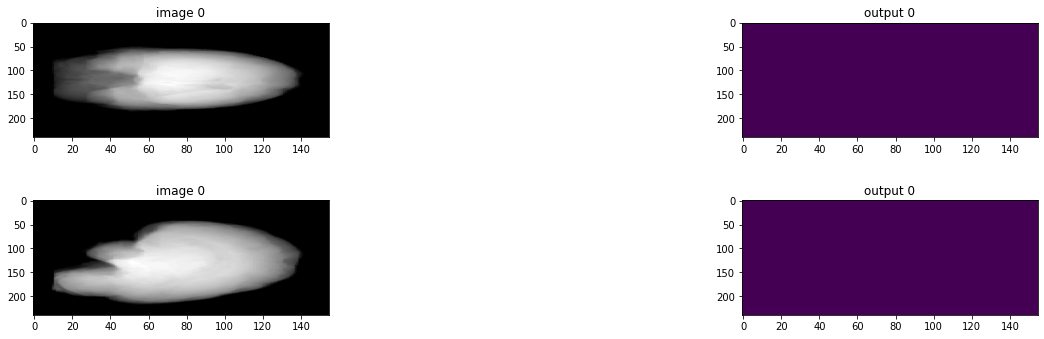

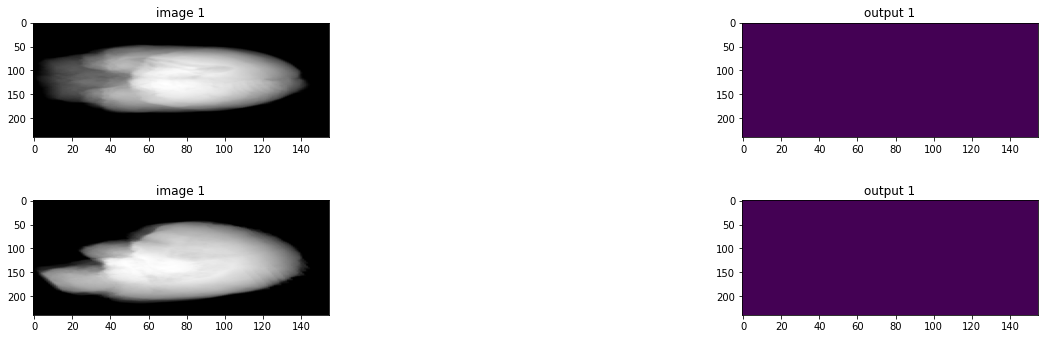

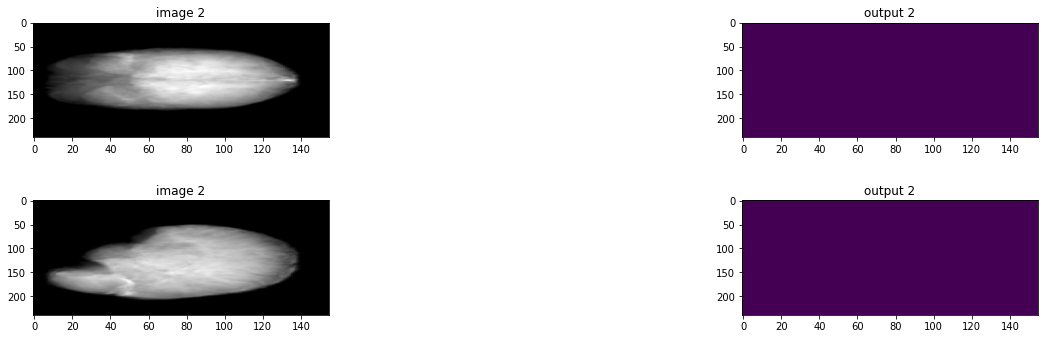

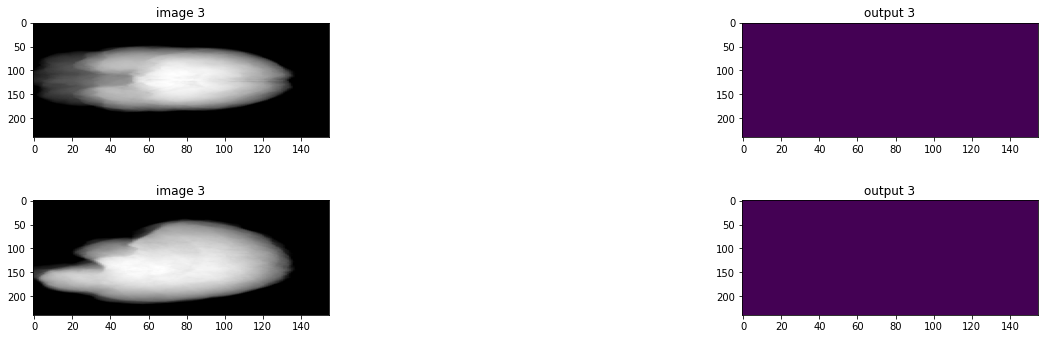

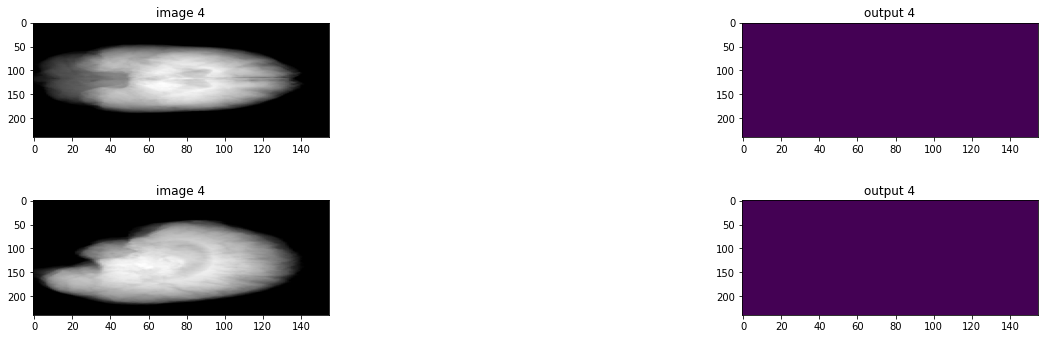

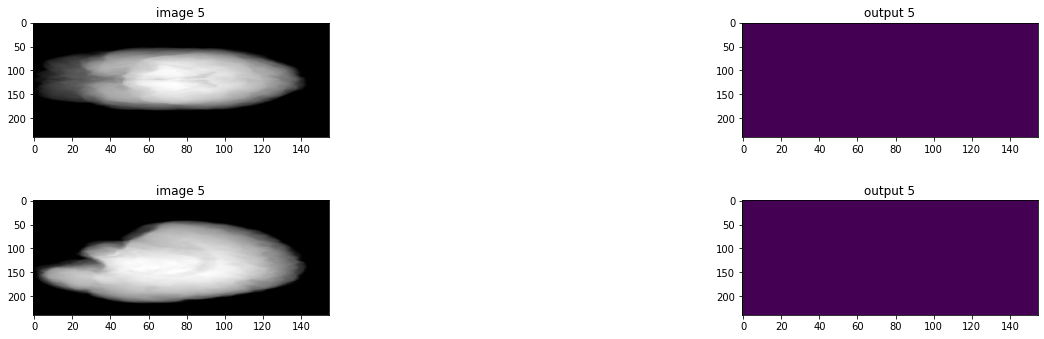

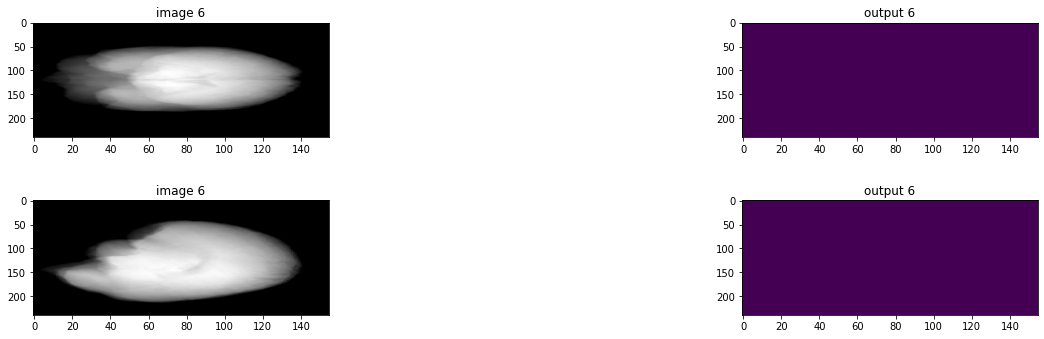

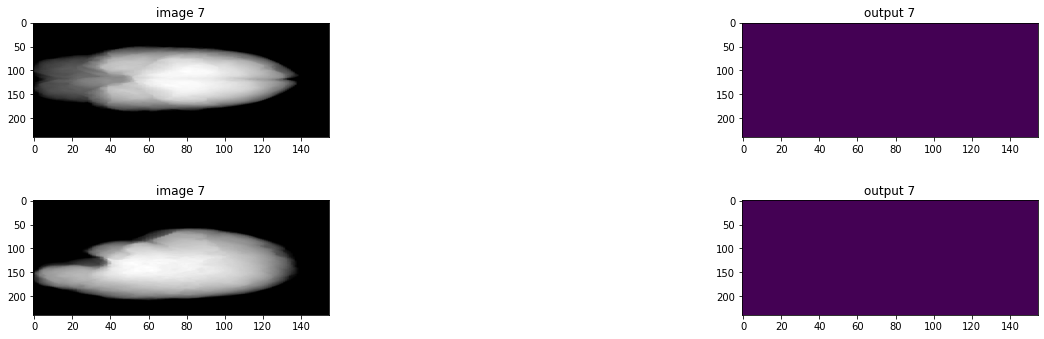

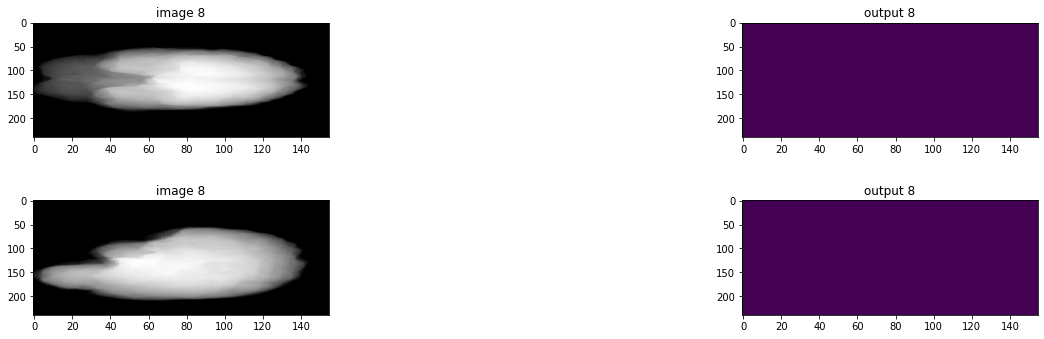

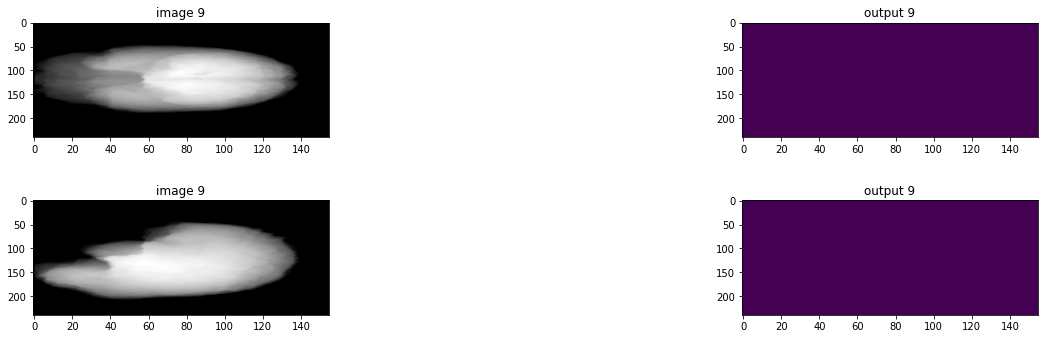

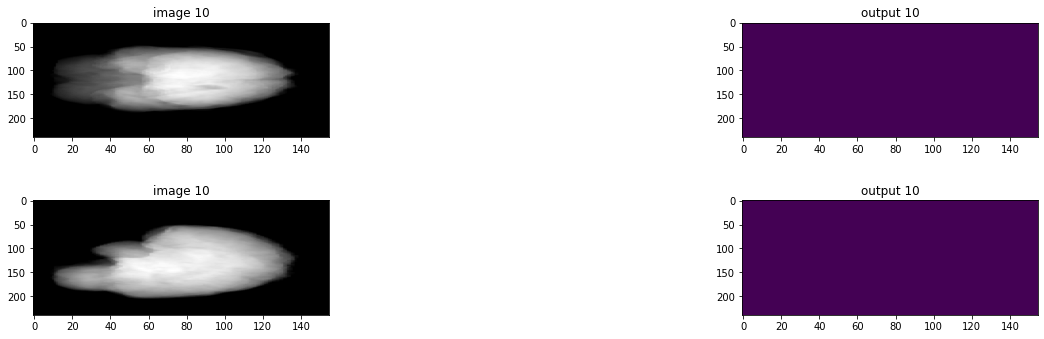

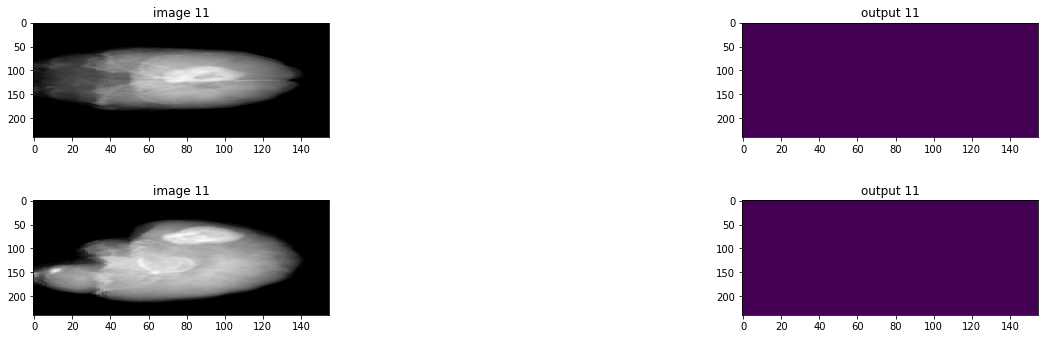

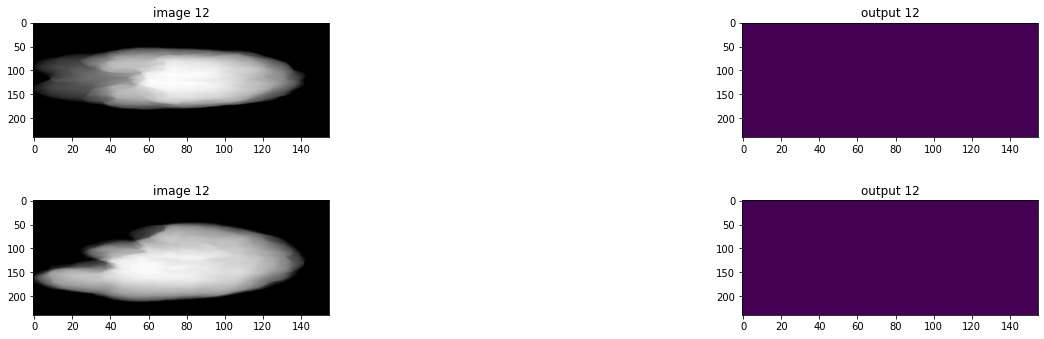

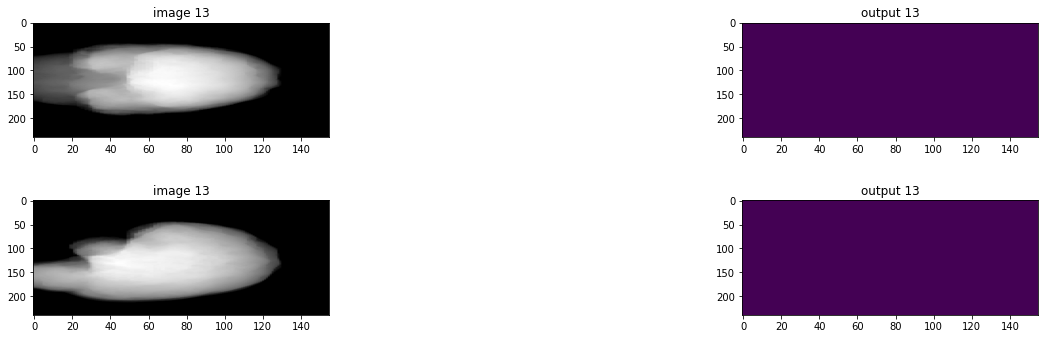

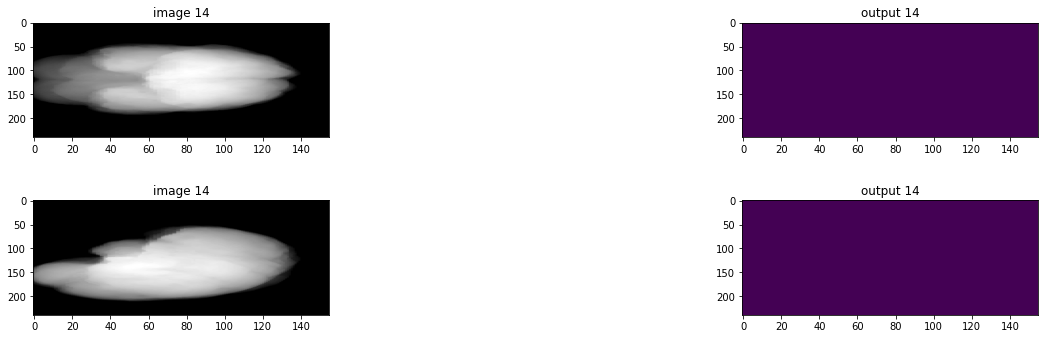

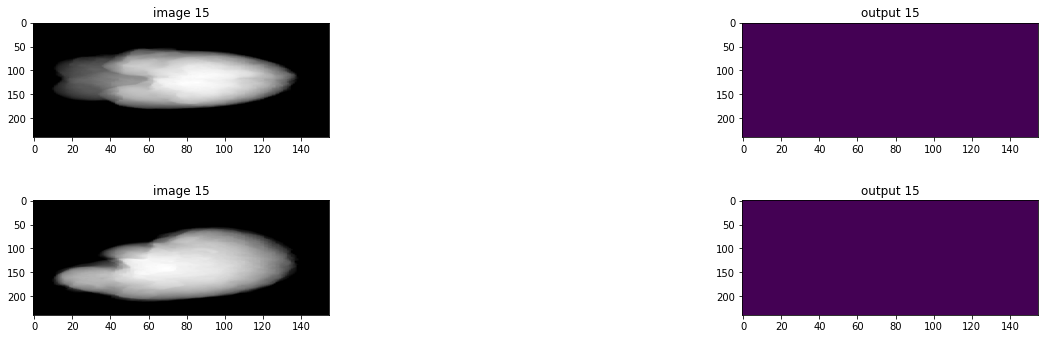

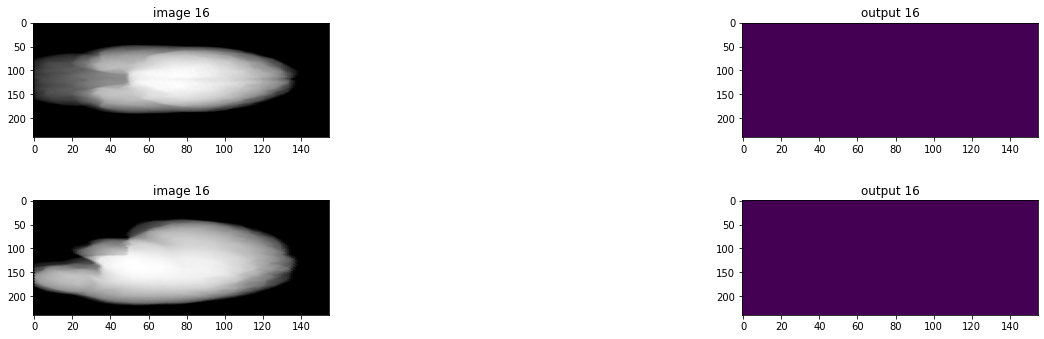

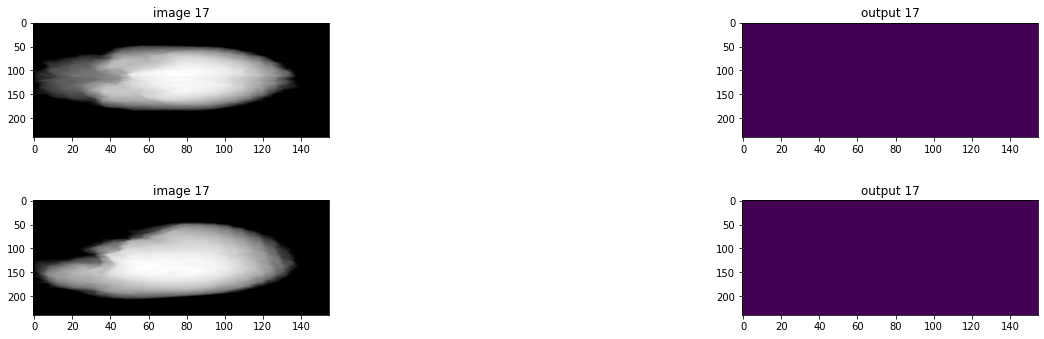

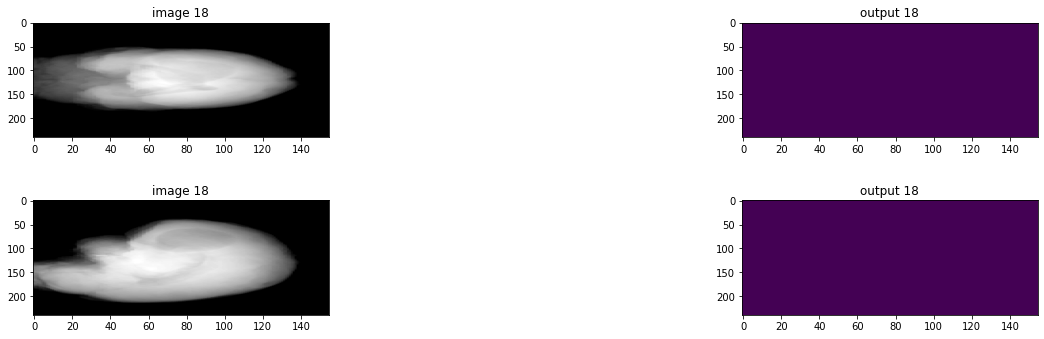

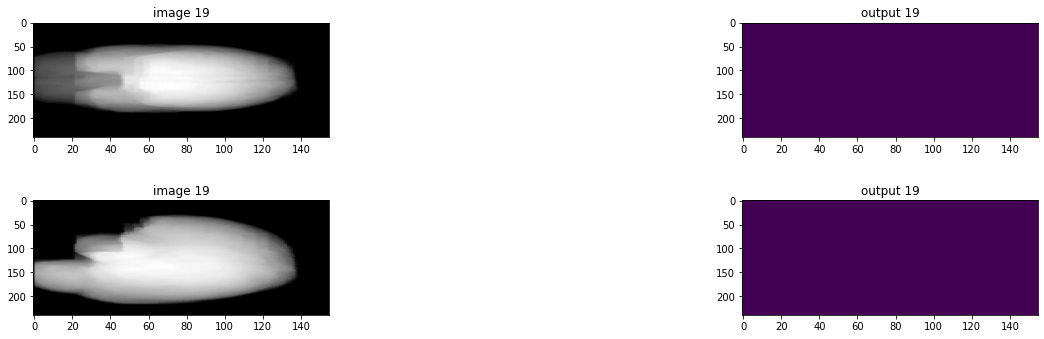

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(data_dir, "best_metric_model.pth"))) # 최상의 dice 값에 대한 모델을 불러옴
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (128, 128, 32)
        sw_batch_size = 16
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model, overlap=0.42
        )
        #tmp = val_data["label"]
        #zz = np.argmax(np.sum(np.sum(np.array(tmp[0,0,:,:,:]),axis=1),axis=0))

        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(2, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(torch.sum(val_data["image"][0, 0, :, :, :],dim=1), cmap="gray",aspect=1/4)
        #plt.subplot(2, 3, 2)
        #plt.title(f"label {i}")
        #plt.imshow(torch.amax(val_data["label"][0, 0, :, :, 15],dim=1),aspect=1/4)
        plt.subplot(2, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.amax(torch.argmax(val_outputs.cpu(), dim=1)[0, :, :, :],dim=1),aspect=1/4)
        plt.subplot(2, 3, 4)
        plt.title(f"image {i}")
        plt.imshow(torch.sum(val_data["image"][0, 0, :, :, :],dim=0), cmap="gray",aspect=1/4)
        #plt.subplot(2, 3, 5)
        #plt.title(f"label {i}")
        #plt.imshow(torch.amax(val_data["label"][0, 0, :, :, :],dim=0),aspect=1/4)
        plt.subplot(2, 3, 6)
        plt.title(f"output {i}")
        plt.imshow(torch.amax(torch.argmax(val_outputs.cpu(), dim=1)[0, :, :, :],dim=0),aspect=1/4)        
#        val_outs = torch.argmax(val_outputs, dim=1).detach().cpu()
#        plt.imshow(np.sum(val_outs[0,:,:,:].numpy(),axis=2))
        plt.show()

        outdir = data_dir
  
        h2 = nib.Nifti1Image(torch.argmax(val_outputs.cpu(), dim=1).numpy().squeeze().astype('float32'),val_data['image_meta_dict']['affine'][0].numpy())
        nib.save(h2,os.path.join(outdir,f"{test_files[i].get('image').split('/')[-2]}.nii.gz"))

In [ ]:
outdir = data_dir

for i in range(len(test_files)):  
  h2 = nib.Nifti1Image(torch.argmax(val_outputs.cpu(), dim=1).numpy().squeeze().astype('float32'),val_data['image_meta_dict']['affine'][0].numpy())
  nib.save(h2,os.path.join(outdir,f"{test_files[i].get('image').split('/')[-2]}.nii.gz"))

AttributeError: ignored

In [ ]:
test_files[1]
print(f'{test_files[1].get("image").split('/')[-2]}.nii.gz')

SyntaxError: ignored